# Summary statistics

In [1]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# parameters
case_id = 0 # run this notebook only once, not for every case
step_id = 9

In [3]:
# included cases hardcoded
case_ids = [1, 2, 3, 5, 6, 7, 8, 9, 10, 13, 15, 16, 17, 18, 19, 20, 21, 22, 25, 26, 29, 30, 41, 42, 43, 44, 45, 46, 49, 51, 53, 54, 55, 58]

In [4]:
df = pd.DataFrame(columns=['MAP', 'COx'])
stats_df = pd.DataFrame()

In [5]:
for cid in case_ids:
    case_str = str(cid).zfill(5)
    input_file = 'output/' + case_str + '_6.csv'
    case_df = pd.read_csv(input_file,
                          sep = ',',
                          na_values = ['-'],
                          parse_dates = ['Time'],
                          index_col = 'Time')

    dur = str(case_df.last_valid_index()-case_df.first_valid_index())[-8:]

    cox_critical = (case_df['COx'] >= 0.30).sum()
    cox_defined_count = case_df['COx'].count()
    cox_above = cox_critical / cox_defined_count
    cox_defined = cox_defined_count / len(case_df.index)

    # dropout
    case_df['rSO2'] = np.where(case_df['Bad_rSO2_manual'] == 1, np.nan, case_df['rSO2'])
    case_df['MAP'] = np.where(case_df['Bad_MAP_auto'] == 1, np.nan, case_df['MAP'])
    case_df['MAP'] = np.where(case_df['Bad_MAP_manual'] == 1, np.nan, case_df['MAP'])

    # gather case stats
    map_mean = case_df['MAP'].mean()
    rso2_mean = case_df['rSO2'].mean()
    cox_mean = case_df['COx'].mean()

    map_sd = case_df['MAP'].std()
    rso2_sd = case_df['rSO2'].std()
    cox_sd = case_df['COx'].std()

    map_median = case_df['MAP'].median()
    rso2_median = case_df['rSO2'].median()
    cox_median = case_df['COx'].median()

    new_row = {"Case ID":cid,
               "Duration":dur,
               "COx defined":f'{cox_defined:.2f}',
               "COx > 0.3":f'{cox_above:.2f}',
               "MAP mean":f'{map_mean:.2f}',
               "MAP SD":f'{map_sd:.2f}',
               "MAP median":f'{map_median:.2f}',
               "rSO2 mean":f'{rso2_mean:.2f}',
               "rSO2 SD":f'{rso2_sd:.2f}',
               "rSO2 median":f'{rso2_median:.2f}',
               "COx mean":f'{cox_mean:.2f}',
               "COx SD":f'{cox_sd:.2f}',
               "COx median":f'{cox_median:.2f}'}
    stats_df = stats_df.append(new_row, ignore_index=True)

    # smooth rSO2 to match MAP
    case_df['rSO2'] = case_df['rSO2'].rolling(10).mean()

    # resampling as per Ono, Joshi, Brady, Easley et al. 2012
    case_df['MAP'] = case_df['MAP'].resample('10s').mean()
    case_df['rSO2'] = case_df['rSO2'].resample('10s').mean()

    f = pd.DataFrame()
    f['MAP'] = np.asarray(case_df['MAP'])
    f['rSO2'] = np.asarray(case_df['rSO2'])
    f['COx'] = np.asarray(case_df['COx'])
    df = df.append(f, ignore_index=True)

In [6]:
stats_df['Case ID'] = stats_df['Case ID'].astype(int)
stats_df.set_index('Case ID', inplace=True)

In [19]:
print(stats_df[['Duration', 'COx defined', 'COx > 0.3', 'MAP mean', 'MAP SD', 'MAP median', 'rSO2 mean', 'rSO2 SD', 'rSO2 median', 'COx mean', 'COx SD', 'COx median']].to_markdown())

|   Case ID | Duration   |   COx defined |   COx > 0.3 |   MAP mean |   MAP SD |   MAP median |   rSO2 mean |   rSO2 SD |   rSO2 median |   COx mean |   COx SD |   COx median |
|----------:|:-----------|--------------:|------------:|-----------:|---------:|-------------:|------------:|----------:|--------------:|-----------:|---------:|-------------:|
|         1 | 01:09:13   |          0.85 |        0.36 |     112.08 |    23.92 |       104.26 |       85.28 |      6.25 |            85 |       0.09 |     0.42 |         0.02 |
|         2 | 00:50:55   |          0.7  |        0.61 |     119.87 |    25.67 |       112.65 |       68.39 |      3.49 |            69 |       0.39 |     0.5  |         0.5  |
|         3 | 01:38:33   |          0.58 |        0.45 |      88.44 |    19.99 |        81.41 |       75.59 |      7.11 |            72 |       0.18 |     0.53 |         0.21 |
|         5 | 01:25:34   |          0.49 |        0.3  |      91.86 |     7.43 |        90.61 |       67.96 |      

In [8]:
df.dropna(inplace=True)
case_str = '00000'

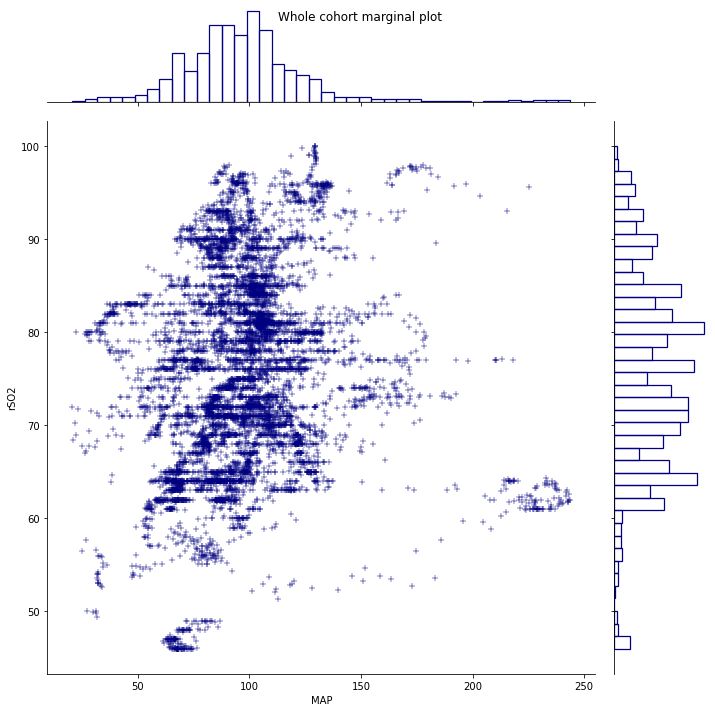

In [9]:
g = sns.jointplot(x="MAP", y="rSO2", data=df, kind='scatter', alpha=1, color="navy", height=10, marginal_kws=dict(bins=40, fill=False), marker='+')
g.fig.suptitle(f'Whole cohort marginal plot')
plt.savefig(f'reports/images/{step_id}_{case_str}_01.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [10]:
def custom_round(x, base=5):
    if (np.isnan(x)): return np.nan
    return base * round(float(x)/base)

In [11]:
df['MAP_rounded'] = df['MAP'].apply(lambda x: custom_round(x, 5))

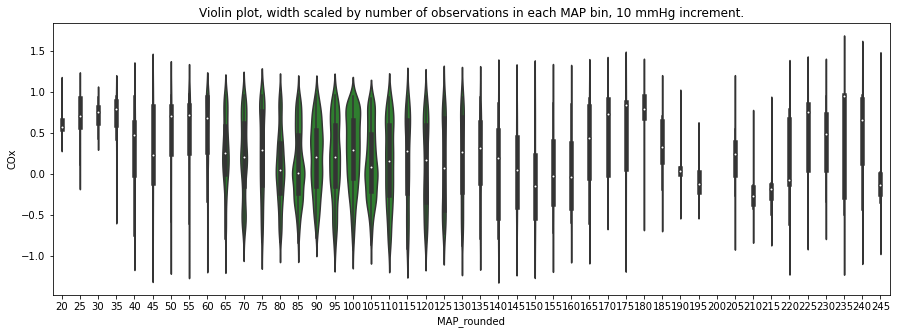

In [12]:
fig, ax = plt.subplots(figsize=(15, 5))
sns.violinplot(x='MAP_rounded', y='COx', data=df, scale="count", color="forestgreen", ax=ax).set_title("Violin plot, width scaled by number of observations in each MAP bin, 10 mmHg increment.")
plt.savefig(f'reports/images/{step_id}_{case_str}_02.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

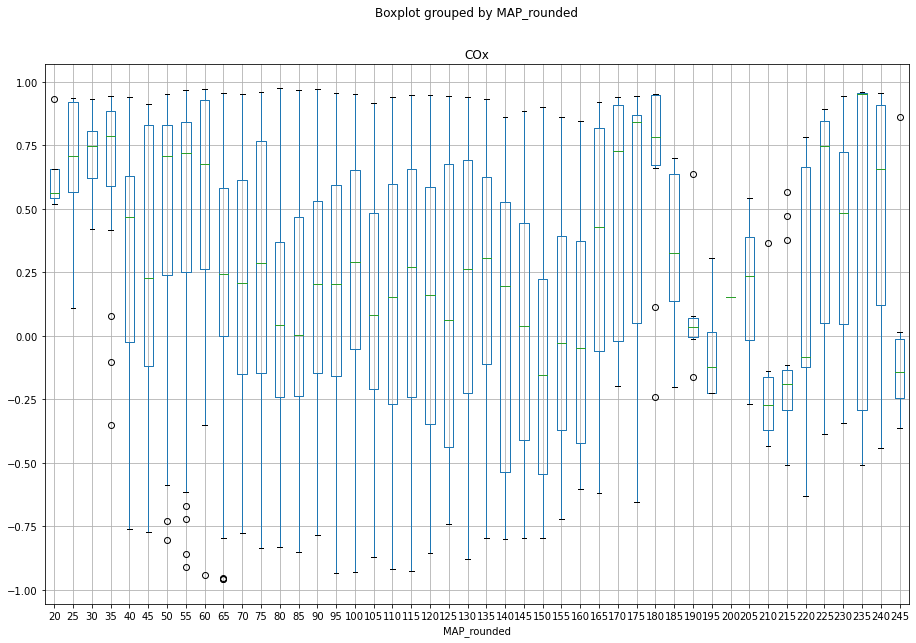

In [13]:
df.boxplot(column = 'COx', by = 'MAP_rounded', figsize = (15, 10));
plt.savefig(f'reports/images/{step_id}_{case_str}_03.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

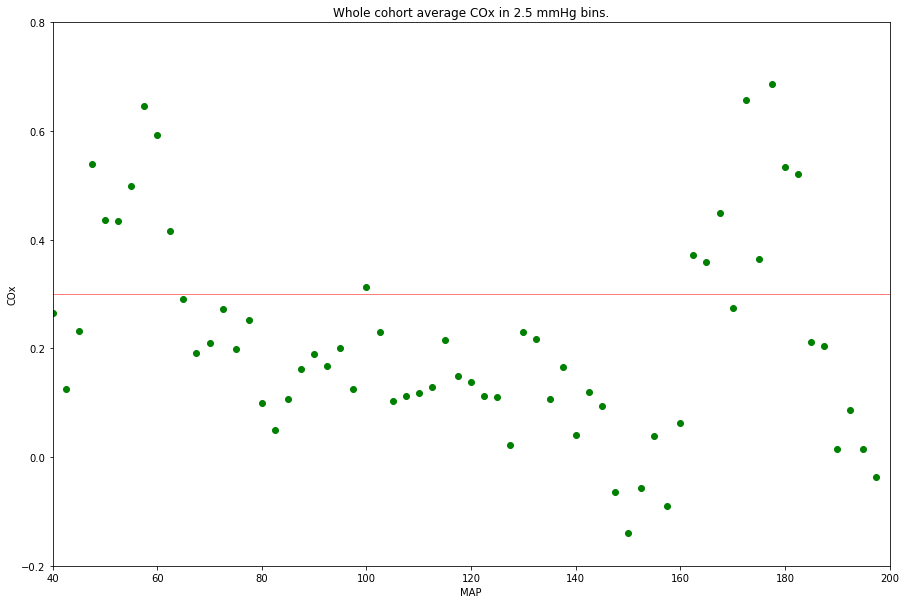

In [14]:
df['MAP_rounded'] = df['MAP'].apply(lambda x: custom_round(x, 2.5))

binned_df = df.groupby(['MAP_rounded']).mean()

fig, ax = plt.subplots(figsize=(15,10))

ax.scatter(binned_df.index, binned_df['COx'], c='g')
ax.set_title(f'Whole cohort average COx in 2.5 mmHg bins.')
ax.set_xlabel('MAP')
ax.set_ylabel('COx')
ax.set_xlim(left=40, right=200)
ax.set_ylim(bottom=-0.2, top=0.8)
ax.axhline(0.3, linewidth=0.5, color="red")
plt.savefig(f'reports/images/{step_id}_{case_str}_04.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

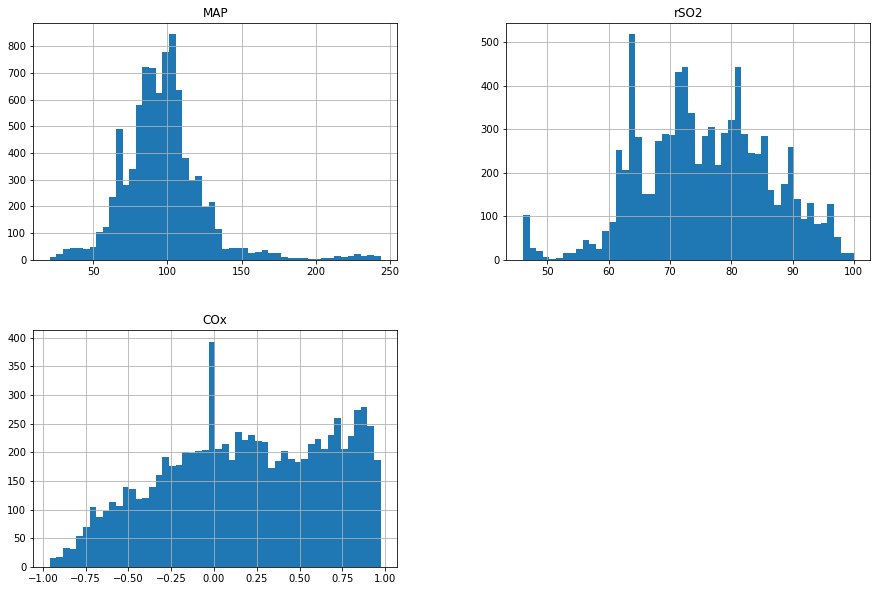

In [15]:
df[['MAP', 'rSO2', 'COx']].hist(bins=50, figsize=(15, 10))
plt.savefig(f'reports/images/{step_id}_{case_str}_05.png', bbox_inches='tight', pad_inches=0.1)
plt.show()

In [16]:
print(f"COx: mean {df['COx'].mean():.2f} median {df['COx'].median():.2f} sd {df['COx'].std():.2f}")
print(f"MAP: mean {df['MAP'].mean():.2f} median {df['MAP'].median():.2f} sd {df['MAP'].std():.2f}")
print(f"rSO2: mean {df['rSO2'].mean():.2f} median {df['rSO2'].median():.2f} sd {df['rSO2'].std():.2f}")

COx: mean 0.19 median 0.20 sd 0.48
MAP: mean 97.04 median 95.74 sd 27.84
rSO2: mean 75.54 median 75.74 sd 10.45
